In [22]:
import os
import numpy as np
import pandas as pd
import numpy.random as rnd
import seaborn as sns
from matplotlib import animation
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sys import platform
import inspect

In [41]:
# Read the data
#set current working directory to where this file is saved
thisdir = globals()['_dh'][0] + "\\" 
os.chdir(thisdir)

if platform == "darwin": 
    # OS X / Mac
    os.environ["PATH"] += os.pathsep + "/usr/local/bin"
elif platform == "win32":
    # Windows
    pass

#path = "/Users/donaldbrown/Dropbox/department/Classes/DS6014/CourseraBayesianML/Week4MCMC/"
file = "2krolls_plus_data.csv"

data = pd.read_csv(file)
# drop adv due to potential dependence
#data = data.drop("adv", axis=1)
data.head()

,id,roll,adv,basis,type
0,0,11,none,initiative,NaN
1,1,10,none,intimidation,check
2,2,19,disadvantage,strength,save
3,3,8,none,dexterity,check
4,4,14,advantage,intimidation,check


In [42]:
file2 = "TravisRollsDataset.csv"

data2 = pd.read_csv(file2)
data2.head()

,id,season,episode,roll,mod,basis,type,adv,critical
0,2,3,1,13,0,wisdom,save,none,none
1,3,3,1,17,0,investigation,check,none,none
2,4,3,1,4,2,dexterity,save,none,none
3,6,3,2,16,7,melee,attack,none,none
4,7,3,2,16,7,melee,attack,advantage,none


In [43]:
# create a column to delineate between simulated data and Travis' rolls
# 0 is a Travis roll
#deter = [0] * len(data2)
data2["deter"] = 0

# 1 is a generated roll
#deter = [1] * len(data)
data["deter"] = 1

In [44]:
# # make list of column names
# 
# col_names.remove("Unnamed: 0")
# col_names.remove("basis_type")
# col_names

In [45]:
# pick out shared columns
col_names = list(data.columns)
merge1 = data[col_names]
merge2 = data2[col_names]

# merge the datasets
total_data_rodeo = pd.concat([merge1, merge2], axis=0).reset_index()

# shuffle the data 3x in replicable way
rodeo = total_data_rodeo.sample(frac=1, random_state=1234567).reset_index(drop=True)
rodeo = rodeo.sample(frac=1, random_state=57389).reset_index(drop=True)
rodeo = rodeo.sample(frac=1, random_state=98754).reset_index(drop=True)
rodeo = rodeo[col_names]

In [46]:
# put rolls into bins
rodeo["new_rolls"] = pd.cut(rodeo.roll, bins=[0, 12, 20], labels=["0-11", "12-20"])
#rodeo = rodeo.drop("roll", axis=1)

In [47]:
series_vals = [str(x) for x in rodeo['roll'].values.tolist()]
cats = [str(x) for x in list(range(1,21))]

rodeo['roll'] = pd.Categorical(series_vals, 
                                   categories= cats,
                                   ordered=False)
rodeo["basis_type"] = rodeo["basis"].astype(str) + "_" + rodeo["type"].astype(str)
rodeo = rodeo.drop("basis", axis=1)
rodeo = rodeo.drop("type", axis=1)
rodeo = rodeo.drop("id", axis=1)

In [48]:
rodeo_dums = pd.get_dummies(rodeo)
rodeo_dums

,deter,roll_1,roll_2,roll_3,roll_4,roll_5,roll_6,roll_7,roll_8,roll_9,...,basis_type_nature_check,basis_type_perception_check,basis_type_persuasion_check,basis_type_ranged_attack,basis_type_sleight of hand_check,basis_type_stealth_check,basis_type_strength_check,basis_type_strength_save,basis_type_thieves’ tools_check,basis_type_wisdom_save
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2166,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2167,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2168,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [49]:
determination = rodeo["deter"]
rolls = rodeo["roll"]

In [50]:
# Build the model with priors and run the sampling
with pm.Model() as chd_model:
    
    # Intercept term & prior
    beta0 = pm.Normal("beta0", mu=0, sd=1)
    # Beta coefficients for predictor variables & priors
    beta = pm.MvNormal("beta", mu=np.zeros(k), cov=np.eye(k), shape=k)
    
    
    # Calculate the logit 
    mu = beta0 + pm.math.dot(X, beta)
    theta = pm.Deterministic("theta",  pm.invlogit(mu))
    # Pass the logits to a Bernoulli outcome, with the observed data
    y_hat = pm.Bernoulli("y_hat", p=theta, observed=y) 
    
    # Sample
    trace_main = pm.sample(10000, cores=1, tune=1000, init='adapt_diag', progressbar=True)

NameError: name 'k' is not defined

In [59]:
## https://docs.pymc.io/notebooks/GLM-linear.html

import pymc3 as pm
from pymc3 import  *

ycol = rodeo_dums.deter
xcols = rodeo_dums.iloc[:,1:]

with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.linear.LinearComponent(x=xcols, y=ycol, intercept=True)
    trace = sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [basis_type_wisdom_save, basis_type_thieves’ tools_check, basis_type_strength_save, basis_type_strength_check, basis_type_stealth_check, basis_type_sleight of hand_check, basis_type_ranged_attack, basis_type_persuasion_check, basis_type_perception_check, basis_type_nature_check, basis_type_melee_attack, basis_type_medicine_check, basis_type_investigation_check, basis_type_intimidation_check, basis_type_insight_check, basis_type_initiative_nan, basis_type_dexterity_save, basis_type_dexterity_check, basis_type_deception_check, basis_type_constitution_save, basis_type_constitution_check, basis_type_charisma_check, basis_type_athletics_check, basis_type_arcana_check, new_rolls_12-20, new_rolls_0-11, adv_none, adv_disadvantage, adv_advantage, roll_20, roll_19, roll_18, roll_17, roll_16, roll_15, roll_14, roll_13, roll_12, roll_11, roll_10, roll_9, roll_8, roll_7, roll

Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [63]:
import arviz as az

az.style.use('arviz-darkgrid')

# Results in table
with model:
    main_idata = az.from_pymc3(trace)
az.summary(main_idata, var_names=xcols.columns, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
roll_1,-3.66,997.32,-1902.22,1813.48,8.51,15.53,13724.24,2063.27,13701.16,4286.47,1.0
roll_2,-3.48,1008.52,-1847.04,1874.94,8.00,15.17,15882.52,2211.79,16313.16,4248.36,1.0
roll_3,-11.72,1007.90,-1813.42,1963.06,7.98,16.09,15971.62,1963.29,16070.14,3872.15,1.0
roll_4,-4.34,973.29,-1928.38,1767.29,7.87,14.69,15311.28,2195.26,15361.33,4073.38,1.0
roll_5,11.69,1003.76,-1954.28,1821.92,8.05,15.81,15555.25,2016.30,15557.63,3976.55,1.0
roll_6,-9.99,1021.26,-1950.08,1889.42,7.56,16.13,18249.13,2005.60,18240.77,4221.79,1.0
roll_7,5.76,984.45,-1827.32,1828.28,7.76,14.50,16086.30,2304.55,16063.53,4333.93,1.0
roll_8,4.53,994.38,-1779.29,1906.28,7.95,15.57,15656.82,2040.85,15639.29,3918.63,1.0
roll_9,-12.56,987.16,-1870.70,1784.38,7.85,14.35,15809.82,2367.02,15799.55,4490.27,1.0
roll_10,12.26,1012.99,-1843.87,1903.34,7.94,15.44,16266.83,2151.74,16265.75,4562.89,1.0


<Figure size 600x1400 with 0 Axes>

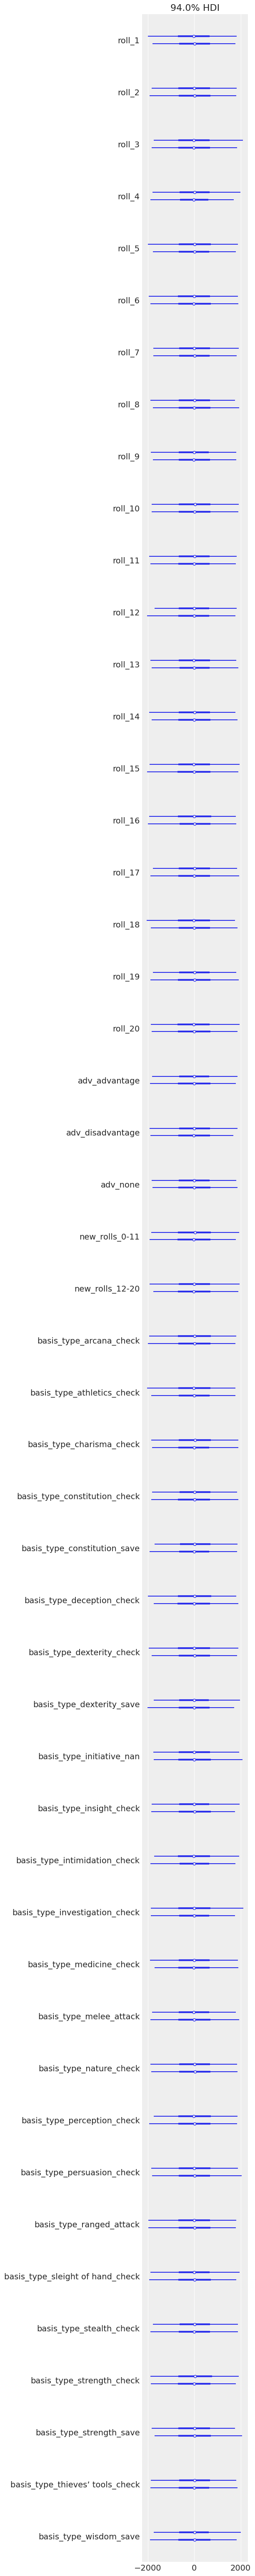

In [64]:
# Forest plots
plt.figure(figsize=(6,14))
with model:
    pm.forestplot(trace, var_names=xcols.columns);